In [1]:
import sys
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

# Add the parent directory to PYTHONPATH so that we can use utils.py
sys.path.append('..')
import utils

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
with open('../data/test_moves.txt', 'r') as f:
    moves = f.read().split()
    
# reduce number of moves for now
moves = moves[:10000]
uniq_moves = list(set(moves))
print('{} unique moves'.format(len(uniq_moves)))

1088 unique moves


In [3]:
window_size = 20
step = 1
inputs = []
outputs = []
for i in range(0, len(moves) - window_size, step):
    inputs.append(moves[i:i + window_size])
    outputs.append(moves[i + window_size])
    
move_to_id = {m:i for i, m in enumerate(uniq_moves)}
id_to_move = {i:m for i, m in enumerate(uniq_moves)}

# using bool to reduce memory usage
X = np.zeros((len(inputs), window_size, len(uniq_moves)), dtype=np.bool)
y = np.zeros((len(inputs), len(uniq_moves)), dtype=np.bool)

# set the appropriate indices to 1 in each one-hot vector
for i, example in enumerate(inputs):
    for t, move in enumerate(example):
        X[i, t, move_to_id[move]] = 1
    y[i, move_to_id[outputs[i]]] = 1

In [4]:
print(X.shape)

(9980, 20, 1088)


In [5]:
model = Sequential()
model.add(LSTM(1024, return_sequences=True, input_shape=(window_size, len(uniq_moves))))
model.add(Dropout(0.5))
model.add(LSTM(512, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(len(uniq_moves)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (None, 20, 1024)      8654848     lstm_input_1[0][0]               
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 20, 1024)      0           lstm_1[0][0]                     
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 512)           3147776     dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 512)           0           lstm_2[0][0]                     
___________________________________________________________________________________________

In [6]:
# more epochs is usually better, but training can be very slow if not on a GPU
epochs = 10
history = model.fit(X, y, batch_size=32, nb_epoch=epochs, validation_split=0.2, verbose=1)

Train on 7984 samples, validate on 1996 samples
Epoch 1/10
7984/7984 [==============================] - 17s - loss: 6.3909 - acc: 0.0139 - val_loss: 6.3055 - val_acc: 0.0145

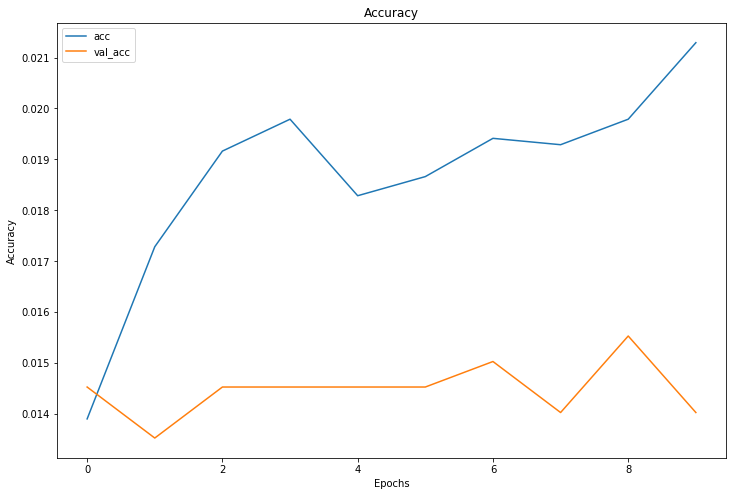

Highest val_acc at epoch 9 with value of 0.016


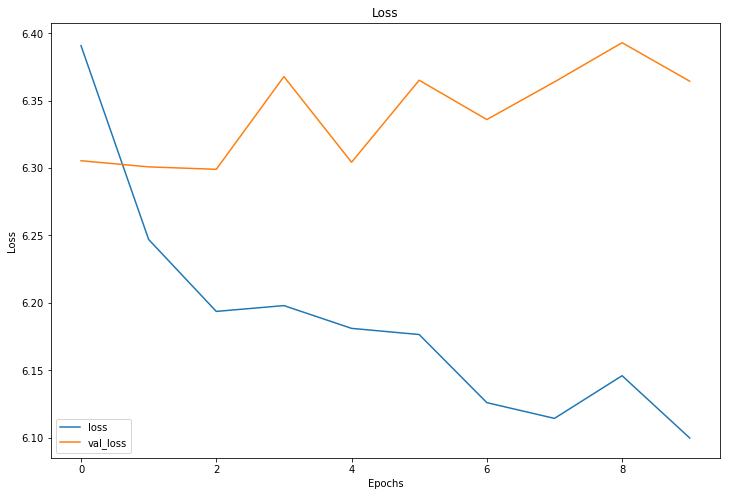

Lowest val_loss at epoch 3 with value of 6.30


In [7]:
utils.plot_model_results(history)   